In [1]:
pip install opendatasets

In [2]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 21.1 MB/s eta 0:00:00


In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/apollo2506/eurosat-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omarali13
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset


100%|██████████| 2.04G/2.04G [00:28<00:00, 77.7MB/s]


In [37]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import rasterio

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')



There are two paths: one for JPG files and another for TIF files. We will work on the JPG files and remove the EuroSAT all bands.




In [6]:
eurosat_allbands_path = "/content/eurosat-dataset/EuroSATallBands"
eurosat_testcsv_path = "/content/eurosat-dataset/EuroSAT/test.csv"
eurosat_traincsv_path = "/content/eurosat-dataset/EuroSAT/train.csv"
eurosat_validcsv_path = "/content/eurosat-dataset/EuroSAT/validation.csv"
json_file = '/content/eurosat-dataset/EuroSAT/label_map.json'

# Remove folder if it exists
if os.path.exists(eurosat_allbands_path) and os.path.isdir(eurosat_allbands_path):
    shutil.rmtree(eurosat_allbands_path)
    print(f"Folder '{eurosat_allbands_path}' removed successfully.")
else:
    print(f"Folder '{eurosat_allbands_path}' does not exist.")

# Function to remove a file safely
def remove_file(file_path):
    if os.path.exists(file_path) and os.path.isfile(file_path):
        os.remove(file_path)
        print(f"File '{file_path}' removed successfully.")
    else:
        print(f"File '{file_path}' does not exist.")

# Remove CSV files
remove_file(eurosat_testcsv_path)
remove_file(eurosat_traincsv_path)
remove_file(eurosat_validcsv_path)
remove_file(json_file)

Folder '/content/eurosat-dataset/EuroSATallBands' removed successfully.
File '/content/eurosat-dataset/EuroSAT/test.csv' removed successfully.
File '/content/eurosat-dataset/EuroSAT/train.csv' removed successfully.
File '/content/eurosat-dataset/EuroSAT/validation.csv' removed successfully.
File '/content/eurosat-dataset/EuroSAT/label_map.json' removed successfully.


In [7]:
# CustomDataset class for loading images and labels
# So we use this function to shuffle all of those files all together to make 1 file for train and 1 file for test
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # List of classes (e.g., AnnualCrop, Forest)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}  # Map class names to indices
        self.image_paths = []

        # Collect all image paths and labels
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            # Only consider directories (skip files like label_map.json)
            if os.path.isdir(class_dir):
                for img in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img)
                    # Only add image files
                    if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                        self.image_paths.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure 3-channel RGB images
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
# Define transformations for training (with augmentation)
# We apply augmentation for train only to avoid data leakage and ensure fair evaluation.
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip vertically
    transforms.RandomRotation(30),  # Randomly rotate by up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Define transformations for validation and testing (without augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load the dataset using CustomDataset
data_dir = "/content/eurosat-dataset/EuroSAT"
dataset = CustomDataset(root_dir=data_dir, transform=val_test_transform)  # Default transform for all data

# Split the dataset into train, validation, and test sets
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    dataset.image_paths, [label for _, label in dataset.image_paths], test_size=0.2, random_state=42,
    stratify=[label for _, label in dataset.image_paths]
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1, random_state=42, stratify=train_labels
)

# Create datasets for train, validation, and test
train_dataset = CustomDataset(root_dir=data_dir, transform=train_transform)
train_dataset.image_paths = train_paths

val_dataset = CustomDataset(root_dir=data_dir, transform=val_test_transform)
val_dataset.image_paths = val_paths

test_dataset = CustomDataset(root_dir=data_dir, transform=val_test_transform)
test_dataset.image_paths = test_paths

In [9]:
# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Testing images: {len(test_dataset)}")

Total images: 27000
Training images: 19440
Validation images: 2160
Testing images: 5400


In [31]:
import rasterio

# Read a sample image
sample_img_path = dataset.image_paths[0][0]
with rasterio.open(sample_img_path) as img:
    num_bands = img.count
    print(f"Number of spectral bands: {num_bands}")

    # Read all bands as an array
    band_data = img.read()

    # Compute stats for each band
    for i in range(num_bands):
        band = band_data[i, :, :]
        print(f"Band {i+1} - Min: {band.min()}, Max: {band.max()}, Mean: {band.mean()}, Std: {band.std()}")

Number of spectral bands: 3
Band 1 - Min: 62, Max: 255, Mean: 173.479248046875, Std: 50.08357330952127
Band 2 - Min: 99, Max: 215, Mean: 156.374267578125, Std: 25.70103642636498
Band 3 - Min: 99, Max: 206, Mean: 147.770263671875, Std: 22.52249753130555


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [11]:
# Missing/Corrupted Files
corrupted_files = []
for img_path, _ in dataset.image_paths:
    try:
        img = Image.open(img_path)  # Attempt to open with PIL
        img.verify()  # Verify file integrity
    except (IOError, SyntaxError) as e:
        corrupted_files.append(img_path)
        print(f"Corrupted file: {img_path}")

print(f"Total corrupted files: {len(corrupted_files)}")

Total corrupted files: 0


Training set samples:


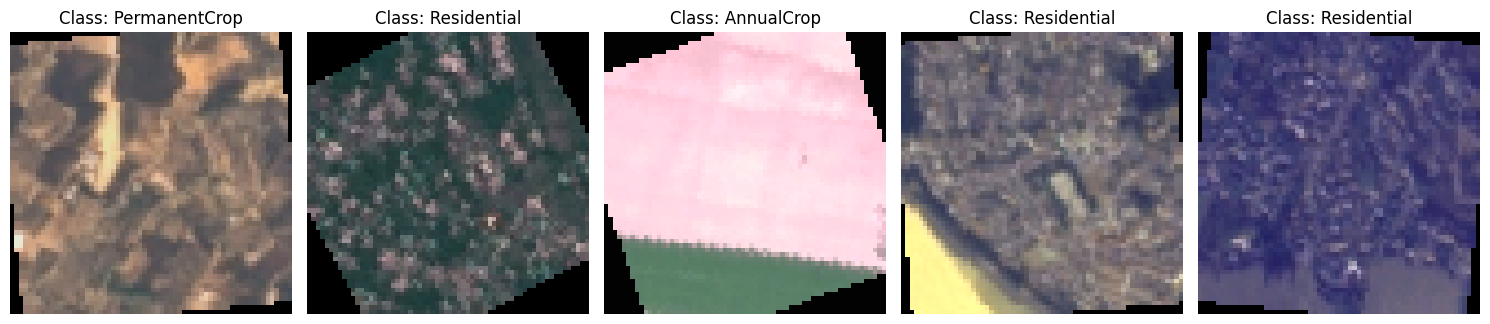

Validation set samples:


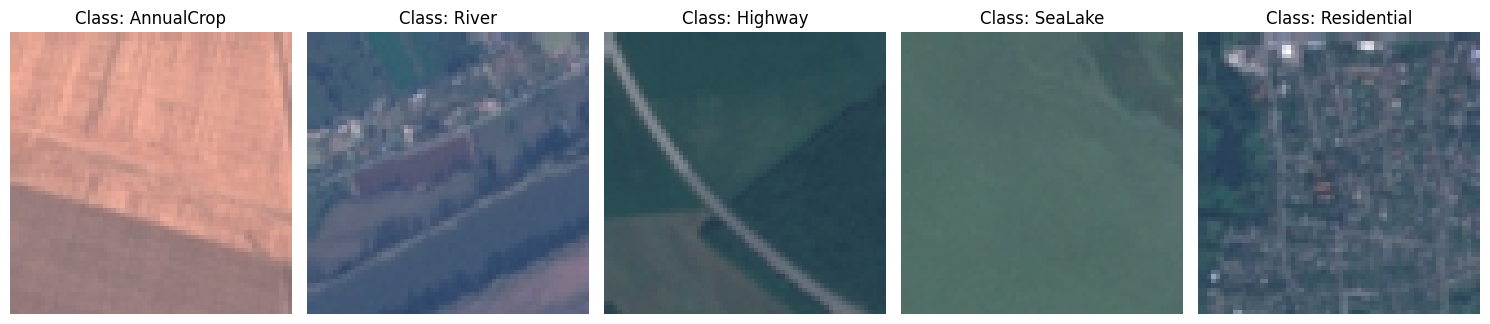

Testing set samples:


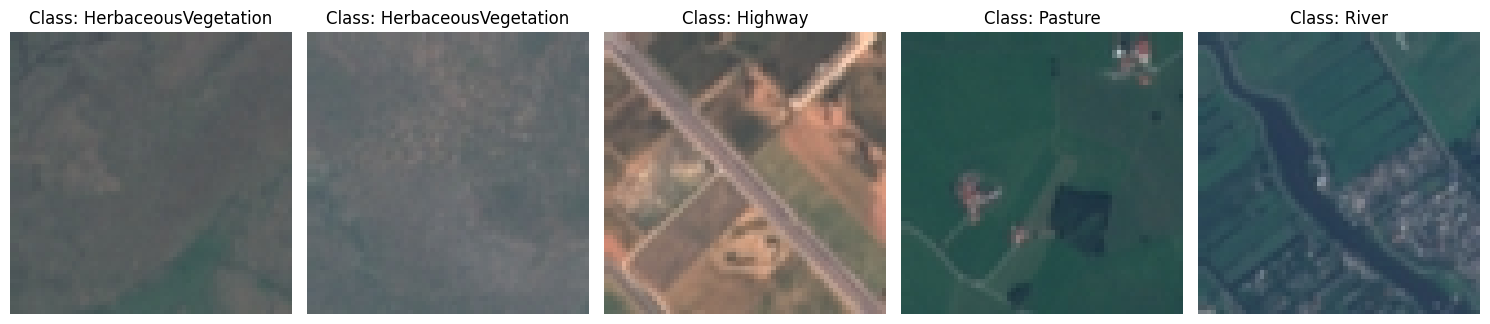

In [12]:
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 5))
    random_indices = random.sample(range(len(dataset)), num_samples)  # Select random indices

    for i, idx in enumerate(random_indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        img = (img * 0.5) + 0.5  # Undo normalization for visualization
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {dataset.classes[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize random samples from train, validation, and test sets
print("Training set samples:")
visualize_samples(train_dataset, num_samples=5)

print("Validation set samples:")
visualize_samples(val_dataset, num_samples=5)

print("Testing set samples:")
visualize_samples(test_dataset, num_samples=5)

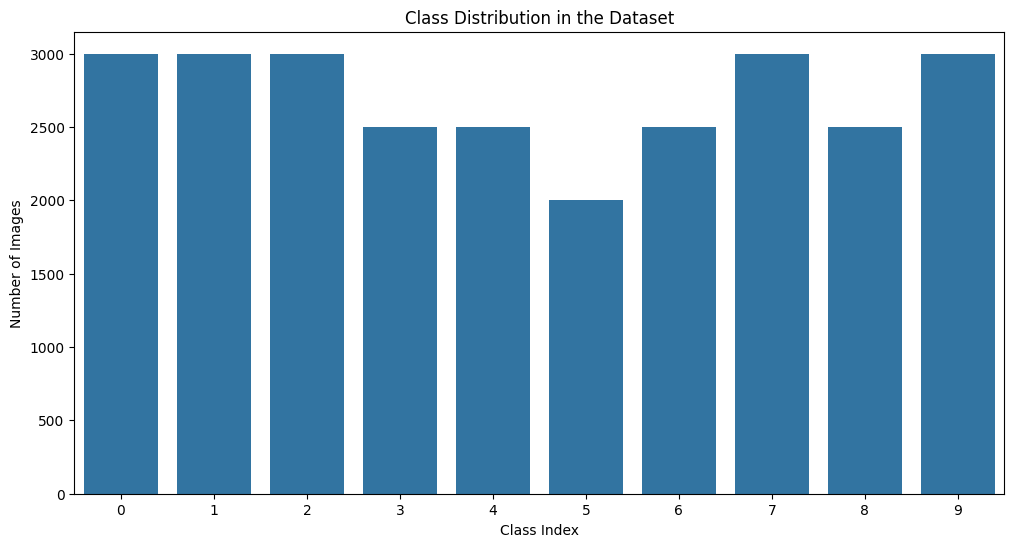

In [32]:
# Count the number of images per class
class_counts = Counter([label for _, label in dataset.image_paths])

# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.title("Class Distribution in the Dataset")
plt.show()

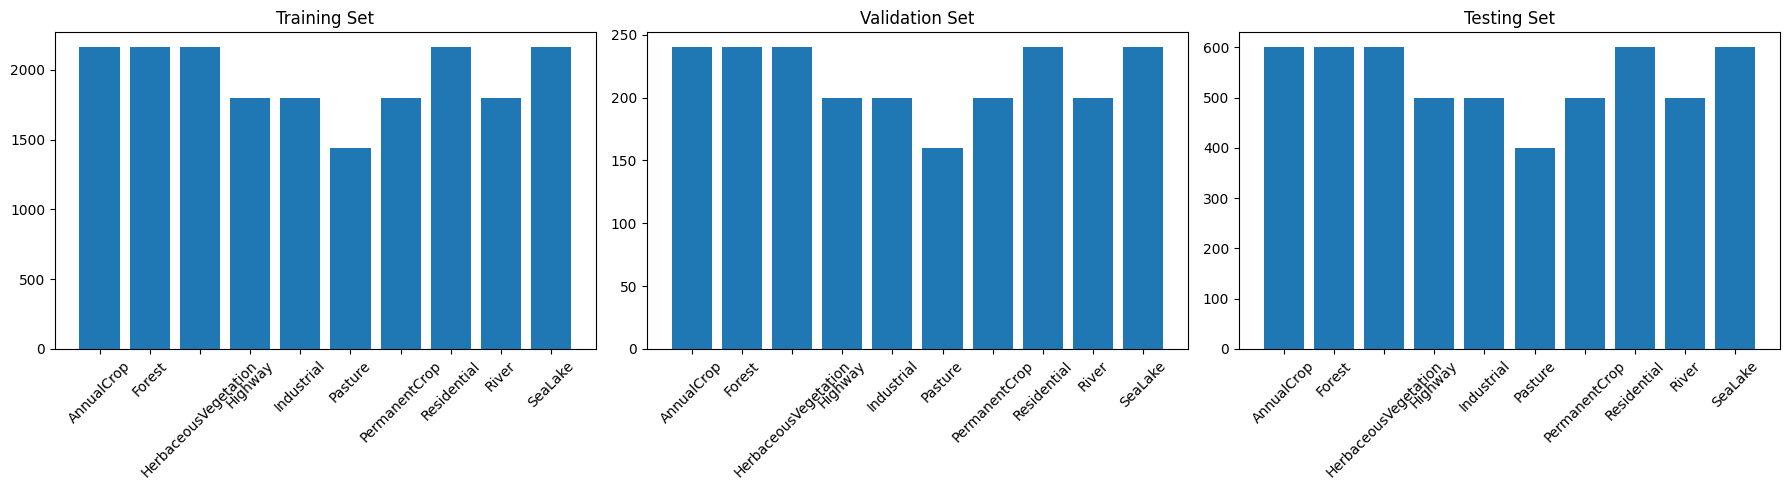

In [13]:
# Inspect Dataset Issues
# Function to plot class distribution in splits
def plot_split_distribution(train_labels, val_labels, test_labels, class_names):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Training set
    train_counts = Counter(train_labels)
    axes[0].bar(class_names, [train_counts[i] for i in range(len(class_names))])
    axes[0].set_title("Training Set")
    axes[0].tick_params(axis='x', rotation=45)

    # Validation set
    val_counts = Counter(val_labels)
    axes[1].bar(class_names, [val_counts[i] for i in range(len(class_names))])
    axes[1].set_title("Validation Set")
    axes[1].tick_params(axis='x', rotation=45)

    # Testing set
    test_counts = Counter(test_labels)
    axes[2].bar(class_names, [test_counts[i] for i in range(len(class_names))])
    axes[2].set_title("Testing Set")
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_split_distribution(train_labels, val_labels, test_labels, dataset.classes)

# Bars for all classes are roughly the same height in all splits, the data is balanced.

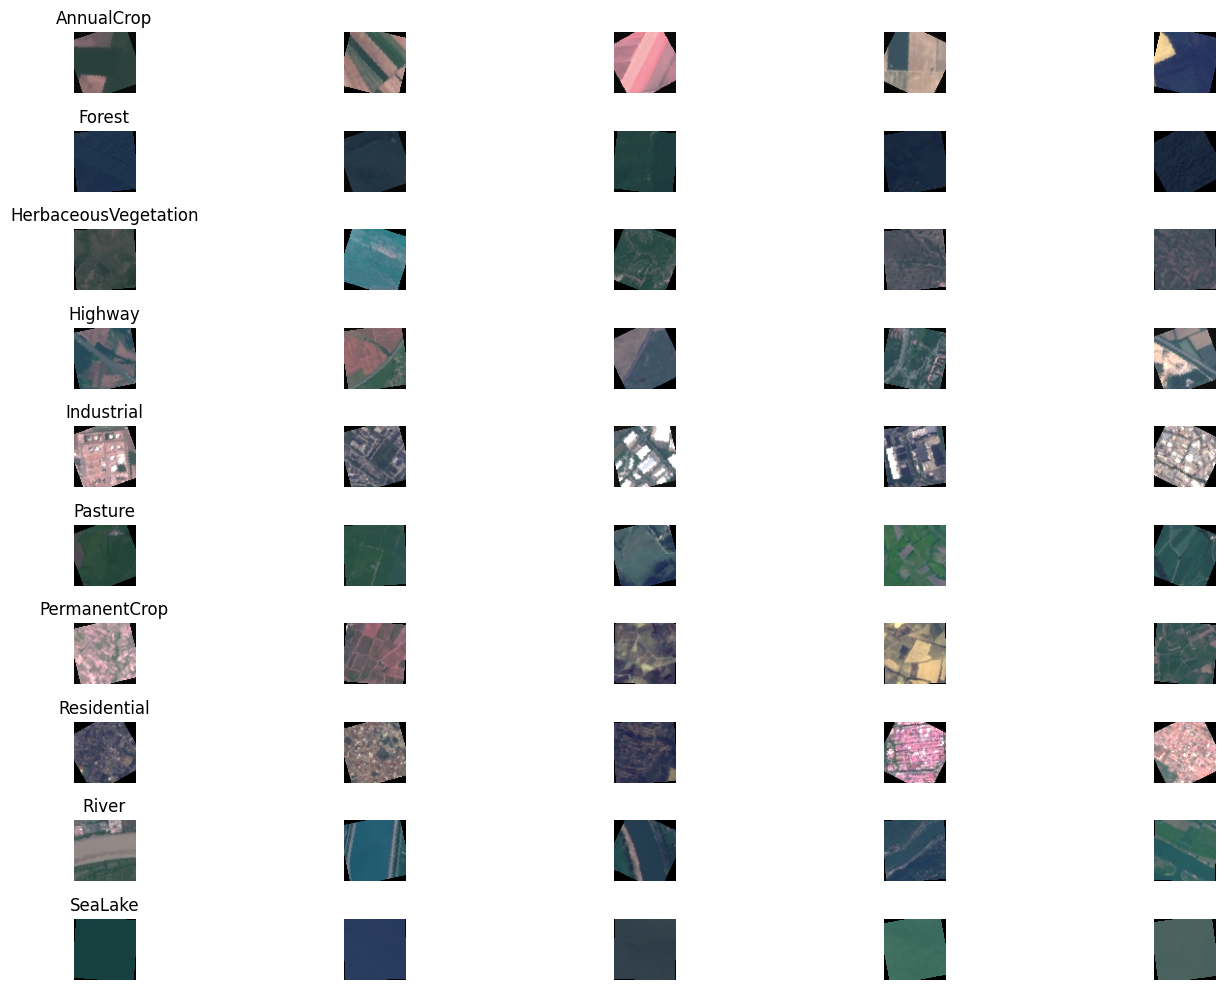

In [14]:
# Visualize Sample Images with RGB Analysis
def visualize_class_samples(dataset, num_samples=5):
    class_indices = {cls: [] for cls in dataset.classes}
    # Collect indices for each class
    for idx in range(len(dataset)):
        _, label = dataset.image_paths[idx]
        class_indices[dataset.classes[label]].append(idx)

    # Plot samples for each class
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(dataset.classes):
        indices = class_indices[cls][:num_samples]
        for j, idx in enumerate(indices):
            img, label = dataset[idx]
            img = img.permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5  # Undo normalization
            plt.subplot(len(dataset.classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{cls}" if j == 0 else "")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_class_samples(train_dataset, num_samples=5)

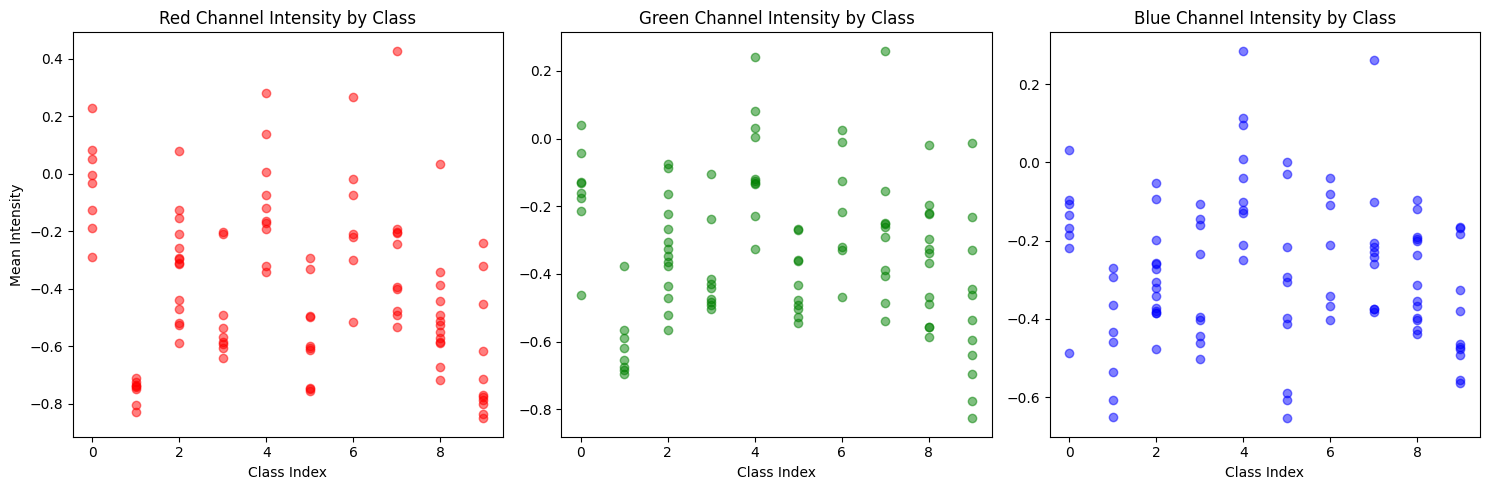

In [15]:
def plot_rgb_distributions(dataset, num_samples=100):
    np.random.seed(42)
    random_indices = np.random.randint(0, len(dataset), num_samples)

    # Initialize arrays to store channel means
    r_means, g_means, b_means = [], [], []
    labels = []

    for idx in random_indices:
        img, label = dataset[idx]
        r_means.append(img[0].mean().item())
        g_means.append(img[1].mean().item())
        b_means.append(img[2].mean().item())
        labels.append(label)

    # Plot distributions
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.scatter(labels, r_means, alpha=0.5, c='red')
    plt.title("Red Channel Intensity by Class")
    plt.xlabel("Class Index")
    plt.ylabel("Mean Intensity")

    plt.subplot(1, 3, 2)
    plt.scatter(labels, g_means, alpha=0.5, c='green')
    plt.title("Green Channel Intensity by Class")
    plt.xlabel("Class Index")

    plt.subplot(1, 3, 3)
    plt.scatter(labels, b_means, alpha=0.5, c='blue')
    plt.title("Blue Channel Intensity by Class")
    plt.xlabel("Class Index")

    plt.tight_layout()
    plt.show()

plot_rgb_distributions(train_dataset)

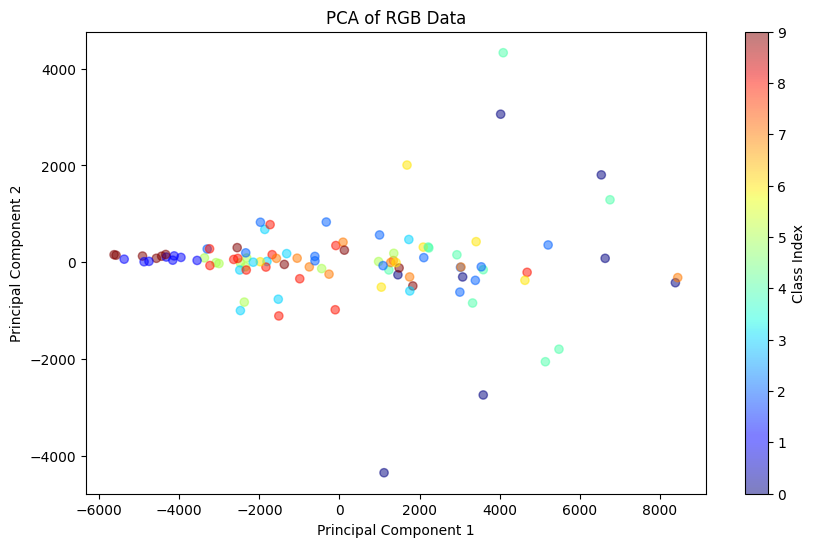

In [16]:
def plot_pca(dataset, num_samples=100):
    np.random.seed(42)
    random_indices = np.random.randint(0, len(dataset), num_samples)

    spectral_data = []
    for idx in random_indices:
        with rasterio.open(dataset.image_paths[idx][0]) as img_raster:
            # Read the bands for RGB
            bands = [img_raster.read(i).flatten() for i in range(1, 4)]  # RGB channels
            spectral_data.append(np.concatenate(bands))

    spectral_data = np.array(spectral_data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(spectral_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=[dataset.image_paths[idx][1] for idx in random_indices], cmap='jet', alpha=0.5)
    plt.title("PCA of RGB Data")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(label="Class Index")
    plt.show()

plot_pca(train_dataset)

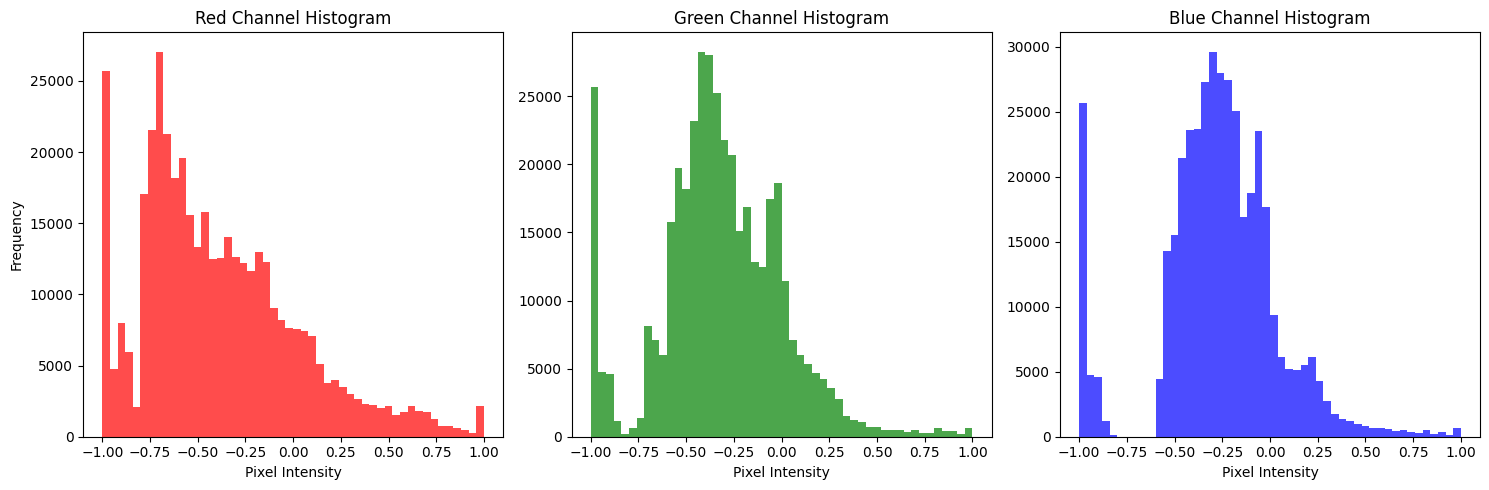

In [17]:
def plot_rgb_histograms(dataset, num_samples=100):
    np.random.seed(42)
    random_indices = np.random.randint(0, len(dataset), num_samples)

    # Initialize arrays to store channel values
    r_values, g_values, b_values = [], [], []

    for idx in random_indices:
        img, _ = dataset[idx]
        r_values.extend(img[0].flatten().numpy())  # Flatten to get all pixel values
        g_values.extend(img[1].flatten().numpy())
        b_values.extend(img[2].flatten().numpy())

    # Plot histograms
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.hist(r_values, bins=50, color='red', alpha=0.7)
    plt.title("Red Channel Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 2)
    plt.hist(g_values, bins=50, color='green', alpha=0.7)
    plt.title("Green Channel Histogram")
    plt.xlabel("Pixel Intensity")

    plt.subplot(1, 3, 3)
    plt.hist(b_values, bins=50, color='blue', alpha=0.7)
    plt.title("Blue Channel Histogram")
    plt.xlabel("Pixel Intensity")

    plt.tight_layout()
    plt.show()

plot_rgb_histograms(train_dataset)

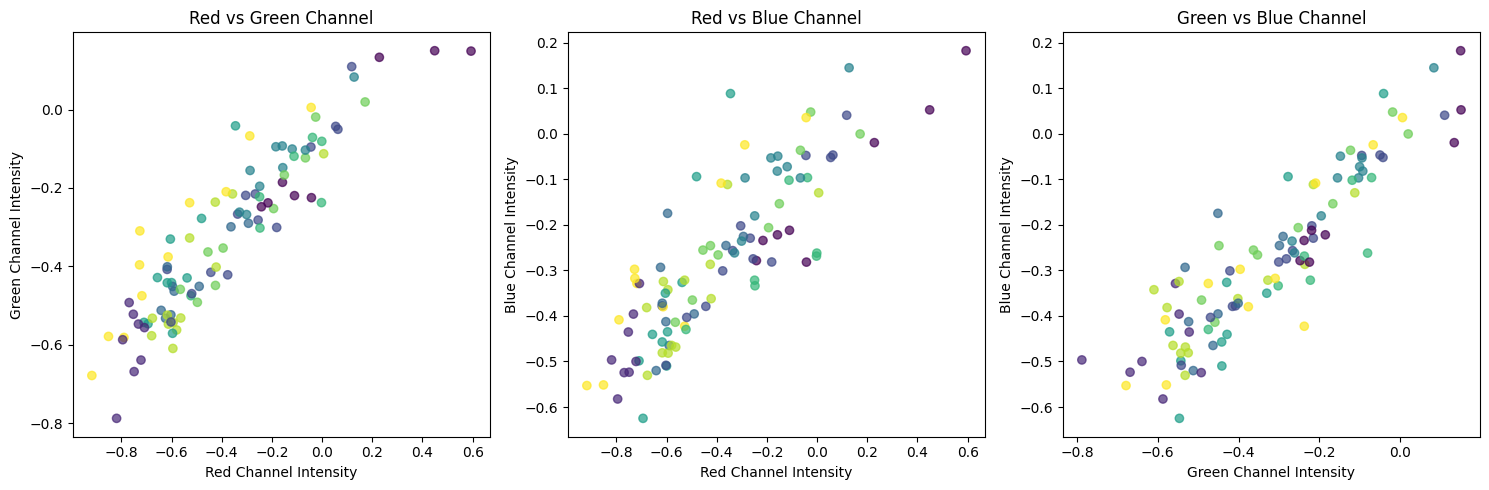

In [18]:
def plot_rgb_scatter(dataset, num_samples=100):
    np.random.seed(42)
    random_indices = np.random.randint(0, len(dataset), num_samples)

    # Initialize arrays to store channel values
    r_values, g_values, b_values = [], [], []
    labels = []

    for idx in random_indices:
        img, label = dataset[idx]
        r_values.append(img[0].mean().item())
        g_values.append(img[1].mean().item())
        b_values.append(img[2].mean().item())
        labels.append(label)

    # Plot scatter plots
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.scatter(r_values, g_values, c=labels, cmap='viridis', alpha=0.7)
    plt.title("Red vs Green Channel")
    plt.xlabel("Red Channel Intensity")
    plt.ylabel("Green Channel Intensity")

    plt.subplot(1, 3, 2)
    plt.scatter(r_values, b_values, c=labels, cmap='viridis', alpha=0.7)
    plt.title("Red vs Blue Channel")
    plt.xlabel("Red Channel Intensity")
    plt.ylabel("Blue Channel Intensity")

    plt.subplot(1, 3, 3)
    plt.scatter(g_values, b_values, c=labels, cmap='viridis', alpha=0.7)
    plt.title("Green vs Blue Channel")
    plt.xlabel("Green Channel Intensity")
    plt.ylabel("Blue Channel Intensity")

    plt.tight_layout()
    plt.show()

plot_rgb_scatter(train_dataset)